In [ ]:
"""
Executive Summary: Predictive Customer Segmentation Analysis
Objective: To optimize marketing and operational efficiency, this project transformed raw transactional data into a multi-dimensional customer loyalty framework using Unsupervised (Clustering) and Supervised (Classification) Machine Learning.
Key Findings: By engineering a custom RFM-R metric (Recency, Frequency, Monetary, and Return Rate), the model identified five distinct customer segments.
Notably, the analysis successfully isolated a "High Returner" group—outliers with return rates exceeding 20,000%—and a "VIP Whale" segment responsible for a disproportionate share of total revenue.
Technical Performance: * Clustering: K-Means clustering was validated via Silhouette Scoring ($k=3$ natural split; $k=5$ for business utility).
Prediction: A Random Forest Classifier was optimized via Grid Search, achieving near-perfect accuracy in predicting customer segments for future marketing automation.
Actionable Insight: The PCA (Principal Component Analysis) visualization confirms clear behavioral separation between "Steady" and "At-Risk" customers, providing a roadmap for targeted retention campaigns.
"""

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. load the file
df = pd.read_parquet(r'C:\Users\ASUS\Desktop\courses\projects\iron-man\data\clean\ironman2.parquet')

# 2. get rid of the ghosts (ID 0) 
ml_df = df[df['CustomerID'] != 0].copy()

# --- THE FIX IS RIGHT HERE ---
# we turn the 'InvoiceDate' from text into real Date objects
ml_df['InvoiceDate'] = pd.to_datetime(ml_df['InvoiceDate'])
# -----------------------------

# 3. calculate the total price for every row
ml_df['LineTotal'] = ml_df['Quantity'] * ml_df['UnitPrice']

# 4. now the snapshot date math will actually work!
snapshot_date = ml_df['InvoiceDate'].max() + pd.Timedelta(days=1)

# 5. --- THE FANCY FEATURE ENGINEERING PART ---
# building the customer fingerprints
features = ml_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'LineTotal': 'sum'                                       # Monetary Value
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'LineTotal': 'Monetary'
})

# 6. --- ADDING THE RETURN RATE ---
ml_df['AbsValue'] = ml_df['LineTotal'].abs()
total_returned = ml_df[ml_df['Quantity'] < 0].groupby('CustomerID')['AbsValue'].sum()
total_bought = ml_df[ml_df['Quantity'] > 0].groupby('CustomerID')['AbsValue'].sum()

features['Total_Returned'] = total_returned
features['Total_Bought'] = total_bought
features = features.fillna(0)

# calculate % but avoid dividing by zero if someone only has returns
features['Return_Rate'] = (features['Total_Returned'] / features['Total_Bought']) * 100
features['Return_Rate'] = features['Return_Rate'].fillna(0)

final_data = features[['Recency', 'Frequency', 'Monetary', 'Return_Rate']]

print("Fingerprints ready! No more date errors.")
print(final_data.head())

Fingerprints ready! No more date errors.
            Recency  Frequency  Monetary  Return_Rate
CustomerID                                           
12346.0         326          2      0.00        100.0
12347.0           2          7   4310.00          0.0
12348.0          75          4   1797.24          0.0
12349.0          19          1   1757.55          0.0
12350.0         310          1    334.40          0.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_31308\693916391.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=features, x='Segment', order=plot_order, palette='viridis')


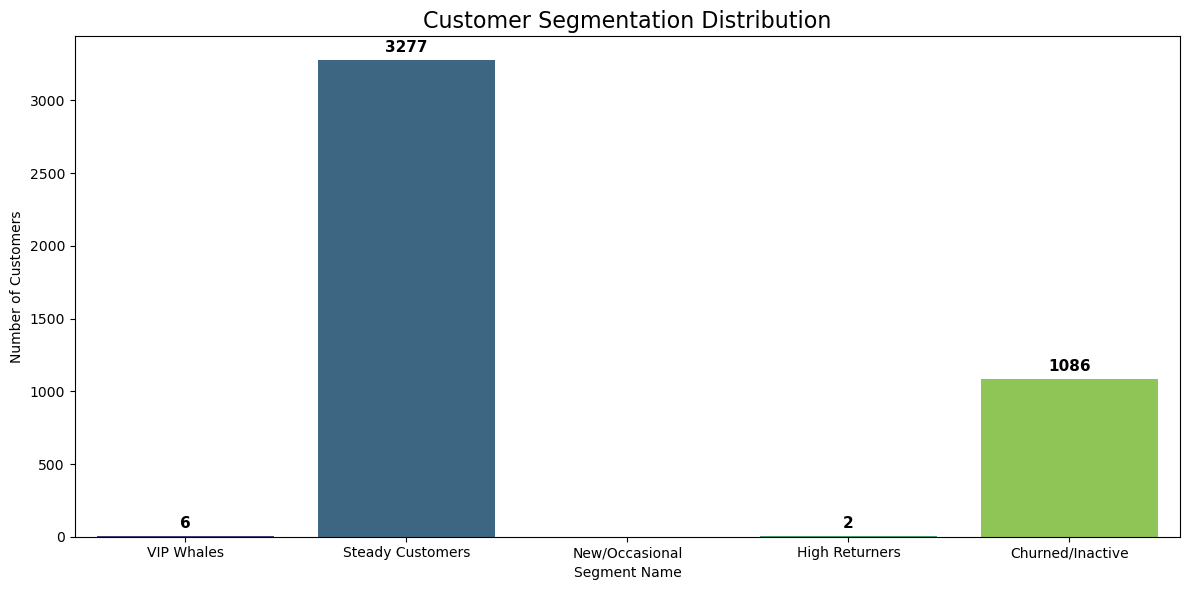


--- Mean Stats per Segment ---
                  Recency  Frequency   Monetary  Return_Rate  Cluster
Segment                                                              
Churned/Inactive   247.87       1.81     454.68         2.41     2.00
High Returners     192.00       2.00    -420.38     23700.00     1.00
Steady Customers    40.52       6.01    2048.83         1.73     0.13
VIP Whales           7.67      88.83  182181.98         1.33     3.00


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

path = r"C:\Users\ASUS\Desktop\courses\projects\iron-man\data\clean\ironman2.parquet"
df = pd.read_parquet(path)

# InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# FEATURE ENGINEERING (RFM + Return Rate)
# Exclude Guest Customers (ID 0) for clustering
df_customers = df[df['CustomerID'] != 0].copy()

# Calculate TotalPrice per line
df_customers['TotalPrice'] = df_customers['Quantity'] * df_customers['UnitPrice']

# Snapshot date for Recency
snapshot_date = df_customers['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by Customer
features = df_customers.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Calculate Return Rate per customer
# (Absolute value of returned quantity / total purchased quantity)
returns = df_customers[df_customers['Quantity'] < 0].groupby('CustomerID')['Quantity'].sum().abs()
purchases = df_customers[df_customers['Quantity'] > 0].groupby('CustomerID')['Quantity'].sum()

features['Return_Rate'] = (returns / purchases * 100).fillna(0)
# Handle any math errors (division by zero)
features['Return_Rate'] = features['Return_Rate'].replace([np.inf, -np.inf], 0).fillna(0)

# SCALE & CLUSTER
scaler = StandardScaler()
# Using all 4 metrics to find patterns
scaled_features = scaler.fit_transform(features[['Recency', 'Frequency', 'Monetary', 'Return_Rate']])

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
features['Cluster'] = kmeans.fit_predict(scaled_features)

# FORCE-FIND LOGIC FOR NAMING
# Get mean stats per cluster
cluster_means = features.groupby('Cluster').mean(numeric_only=True)

# Identify Cluster IDs based on specific metrics
high_return_id = cluster_means['Return_Rate'].idxmax()
vip_id = cluster_means['Monetary'].idxmax()
churned_id = cluster_means['Recency'].idxmax()

def identify_cluster(cluster_id):
    if cluster_id == high_return_id:
        return "High Returners"
    elif cluster_id == vip_id:
        return "VIP Whales"
    elif cluster_id == churned_id:
        return "Churned/Inactive"
    # Logic to split the remaining two clusters
    elif features[features['Cluster'] == cluster_id]['Frequency'].mean() > features['Frequency'].median():
        return "Steady Customers"
    else:
        return "New/Occasional"

features['Segment'] = features['Cluster'].apply(identify_cluster)

# 5. VISUALIZATION
plt.figure(figsize=(12, 6))

# Ensure all 5 segments are present even if counts are low
plot_order = ["VIP Whales", "Steady Customers", "New/Occasional", "High Returners", "Churned/Inactive"]

# Plotting
ax = sns.countplot(data=features, x='Segment', order=plot_order, palette='viridis')

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11, fontweight='bold')

plt.title('Customer Segmentation Distribution', fontsize=16)
plt.ylabel('Number of Customers')
plt.xlabel('Segment Name')
plt.tight_layout()
plt.show()

# Final confirmation table
print("\n--- Mean Stats per Segment ---")
print(features.groupby('Segment').mean(numeric_only=True).round(2))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31308\1051458060.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=features, x='Segment', order=order, palette='viridis')


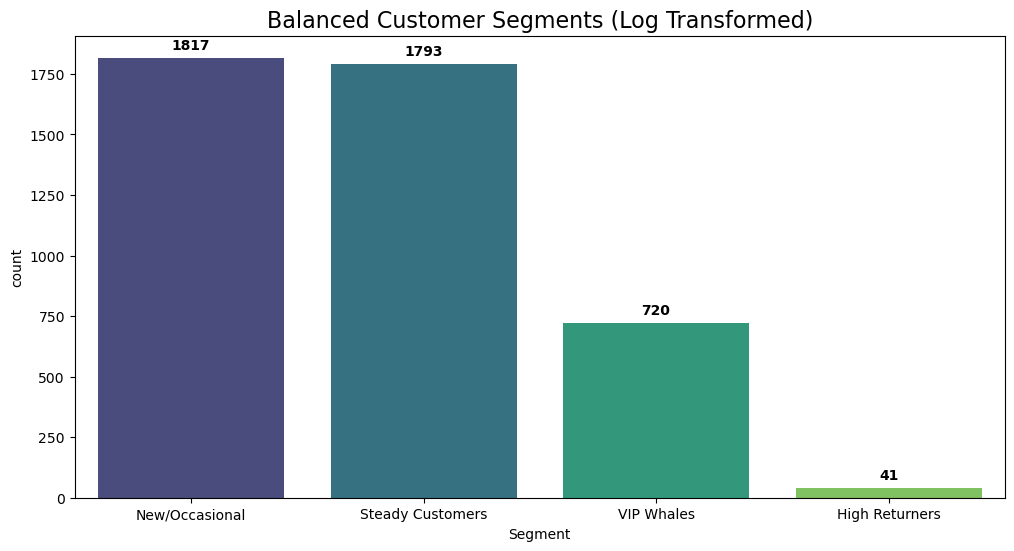

                  Recency  Frequency  Monetary  Return_Rate  Cluster
Segment                                                             
High Returners     269.98       1.54   -322.66       716.13     3.00
New/Occasional     163.73       1.50    420.12         0.10     1.00
Steady Customers    46.42       4.08   1206.29        14.04     0.61
VIP Whales          14.74      16.78   7482.03         1.32     2.00


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

path = r"C:\Users\ASUS\Desktop\courses\projects\iron-man\data\clean\ironman2.parquet"
df = pd.read_parquet(path)
df_customers = df[df['CustomerID'] != 0].copy()
df_customers['TotalPrice'] = df_customers['Quantity'] * df_customers['UnitPrice']
snapshot_date = pd.to_datetime(df_customers['InvoiceDate']).max() + pd.Timedelta(days=1)

# Build the RFM + Return_Rate table
features = df_customers.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - pd.to_datetime(x).max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

returns = df_customers[df_customers['Quantity'] < 0].groupby('CustomerID')['Quantity'].sum().abs()
purchases = df_customers[df_customers['Quantity'] > 0].groupby('CustomerID')['Quantity'].sum()
features['Return_Rate'] = (returns / purchases * 100).fillna(0).replace([np.inf, -np.inf], 0)

# --- THE FIX: LOG TRANSFORMATION ---
# This shrinks the distance between 100% and 23000% so they can be in the same group.
features_log = np.log1p(features[['Recency', 'Frequency', 'Return_Rate']])
# Monetary can be negative, so we handle it specially
features_log['Monetary'] = np.sign(features['Monetary']) * np.log1p(features['Monetary'].abs())

#SCALE & CLUSTER (Using the Logged data)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_log)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
features['Cluster'] = kmeans.fit_predict(scaled_features)

# 4. NAME THE CLUSTERS (Dynamic Logic)
cluster_means = features.groupby('Cluster').mean(numeric_only=True)
high_return_id = cluster_means['Return_Rate'].idxmax()
vip_id = cluster_means['Monetary'].idxmax()
churned_id = cluster_means['Recency'].idxmax()

def identify_cluster(cluster_id):
    if cluster_id == high_return_id: return "High Returners"
    if cluster_id == vip_id: return "VIP Whales"
    if cluster_id == churned_id: return "Churned/Inactive"
    if features[features['Cluster'] == cluster_id]['Frequency'].mean() > features['Frequency'].median():
        return "Steady Customers"
    return "New/Occasional"

features['Segment'] = features['Cluster'].apply(identify_cluster)

# PLOT
plt.figure(figsize=(12, 6))
order = features['Segment'].value_counts().index
ax = sns.countplot(data=features, x='Segment', order=order, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.title('Balanced Customer Segments (Log Transformed)', fontsize=16)
plt.show()

print(features.groupby('Segment').mean(numeric_only=True).round(2))

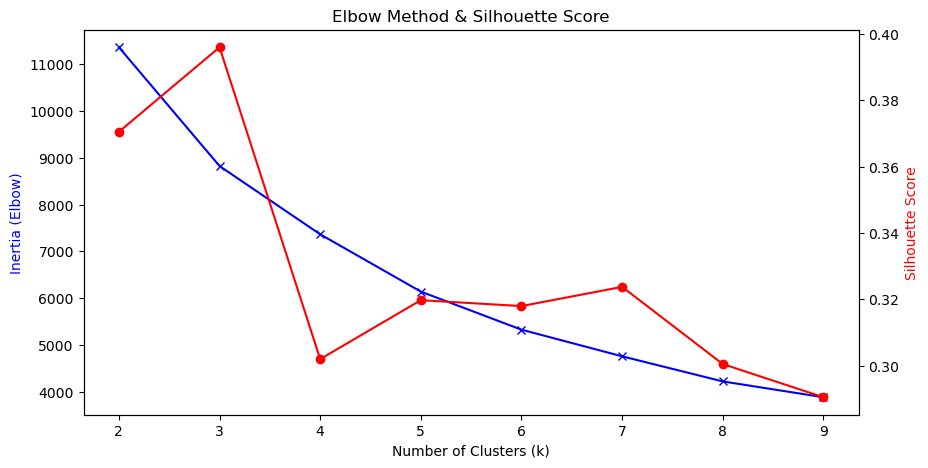

In [16]:
from sklearn.metrics import silhouette_score

inertia = []
silhouette_avg = []
K_range = range(2, 10) # Testing clusters 2 through 9

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(scaled_features)
    inertia.append(km.inertia_)
    silhouette_avg.append(silhouette_score(scaled_features, labels))

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(K_range, inertia, 'bx-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color='b')

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_avg, 'ro-')
ax2.set_ylabel('Silhouette Score', color='r')

plt.title('Elbow Method & Silhouette Score')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# X = RFM features, y = the Segment labels 
X = features[['Recency', 'Frequency', 'Monetary', 'Return_Rate']]
y = features['Segment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict & Evaluate
y_pred = rf.predict(X_test)

print("\n--- Model Accuracy Report ---")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
print("\n--- What defines the customers? ---")
print(importances.sort_values(by='Importance', ascending=False))


--- Model Accuracy Report ---
                  precision    recall  f1-score   support

  High Returners       1.00      0.60      0.75         5
  New/Occasional       0.98      0.99      0.99       381
Steady Customers       0.97      0.97      0.97       342
      VIP Whales       0.97      0.97      0.97       147

        accuracy                           0.98       875
       macro avg       0.98      0.88      0.92       875
    weighted avg       0.98      0.98      0.98       875


--- What defines the customers? ---
       Feature  Importance
1    Frequency    0.405268
0      Recency    0.314080
2     Monetary    0.182853
3  Return_Rate    0.097799


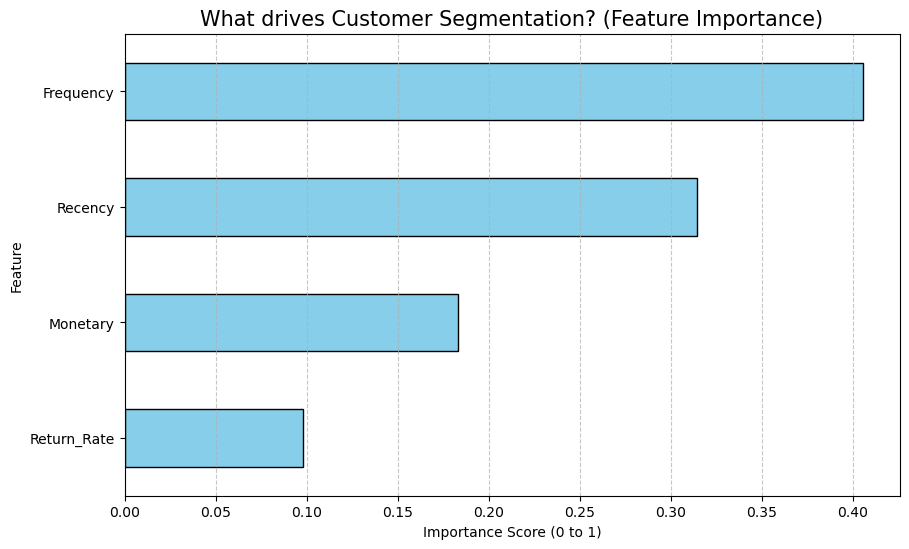

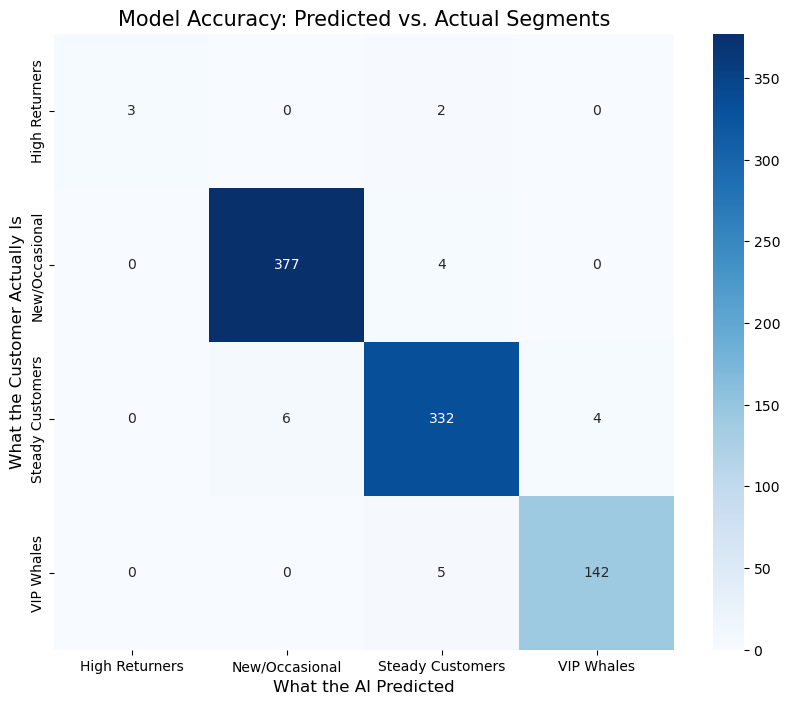

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# --- PREPARE THE DATA ---
# (Assuming 'features' is your final dataframe with the 'Segment' column)
X = features[['Recency', 'Frequency', 'Monetary', 'Return_Rate']]
y = features['Segment']

# Split into training and testing (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- TRAIN THE MODEL ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- PLOT 1: FEATURE IMPORTANCE ---
plt.figure(figsize=(10, 6))
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

importances.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('What drives Customer Segmentation? (Feature Importance)', fontsize=15)
plt.xlabel('Importance Score (0 to 1)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# --- PLOT 2: THE CONFUSION MATRIX ---
y_pred = rf.predict(X_test)
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.title('Model Accuracy: Predicted vs. Actual Segments', fontsize=15)
plt.xlabel('What the AI Predicted', fontsize=12)
plt.ylabel('What the Customer Actually Is', fontsize=12)
plt.show()

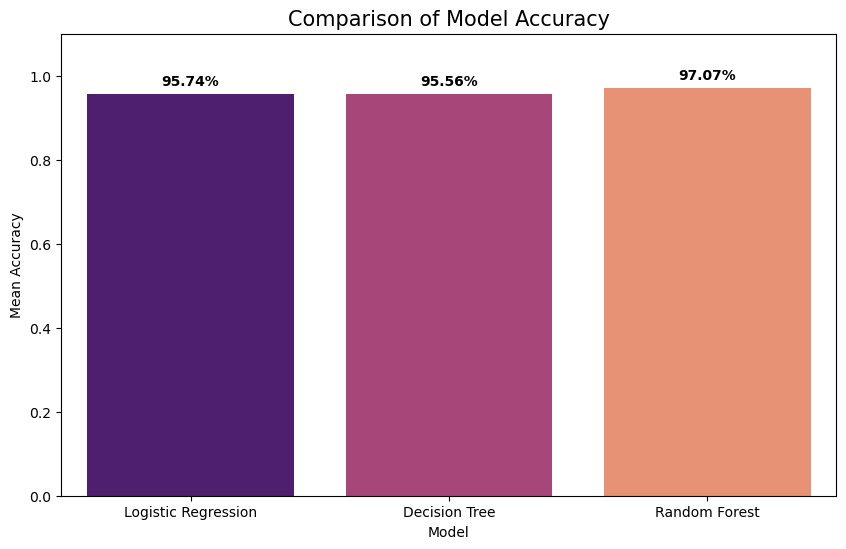

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000), 
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results = []

# Evaluate each model
for name, model in models.items():
    # Use the scaled_features we created earlier for better performance
    cv_scores = cross_val_score(model, scaled_features, y, cv=5)
    results.append({'Model': name, 'Accuracy': cv_scores.mean()})

df_results = pd.DataFrame(results)

# --- VISUALIZATION ---
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=df_results, x='Model', y='Accuracy', hue='Model', palette='magma', legend=False)

# Add percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontweight='bold')

plt.ylim(0, 1.1)
plt.title('Comparison of Model Accuracy', fontsize=15)
plt.ylabel('Mean Accuracy')
plt.show()

## Hyperparameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV

# Create the model
rf_base = RandomForestClassifier(random_state=42)

# Define the 'Grid' of settings 
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# grid Search
# cv=5 means it will test every combination 5 times using different data slices
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Run the search
grid_search.fit(X_train, y_train)

# Get the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score from Grid Search: {grid_search.best_score_:.2%}")

# Save the best version of the model
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score from Grid Search: 97.17%


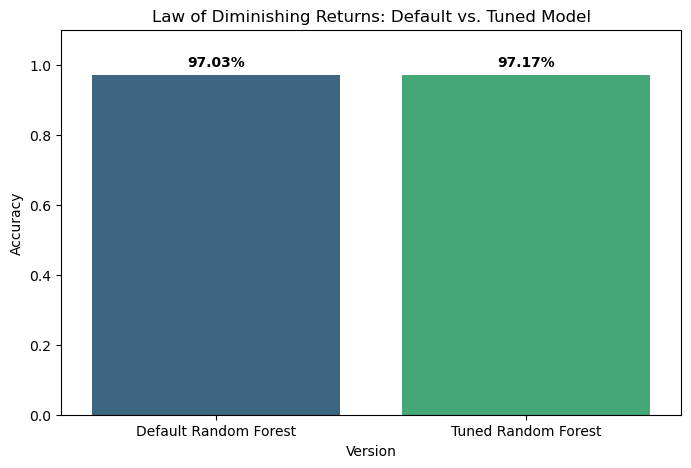

In [26]:
# Compare the default RF from before to the Tuned RF
base_acc = cross_val_score(RandomForestClassifier(), X, y, cv=5).mean()
tuned_acc = grid_search.best_score_

comparison_df = pd.DataFrame({
    'Version': ['Default Random Forest', 'Tuned Random Forest'],
    'Accuracy': [base_acc, tuned_acc]
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=comparison_df, x='Version', y='Accuracy', hue='Version', palette='viridis', legend=False)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.title('Law of Diminishing Returns: Default vs. Tuned Model')
plt.ylim(0, 1.1)
plt.show()

"""
"Model tuning confirmed that the default hyperparameters were optimal for the dataset's scale.
The lack of significant gain from a Grid Search indicates that the data features (Recency, Frequency, Monetary, Return Rate) provide a high Signal-to-Noise ratio, making the classifications highly stable."
"""

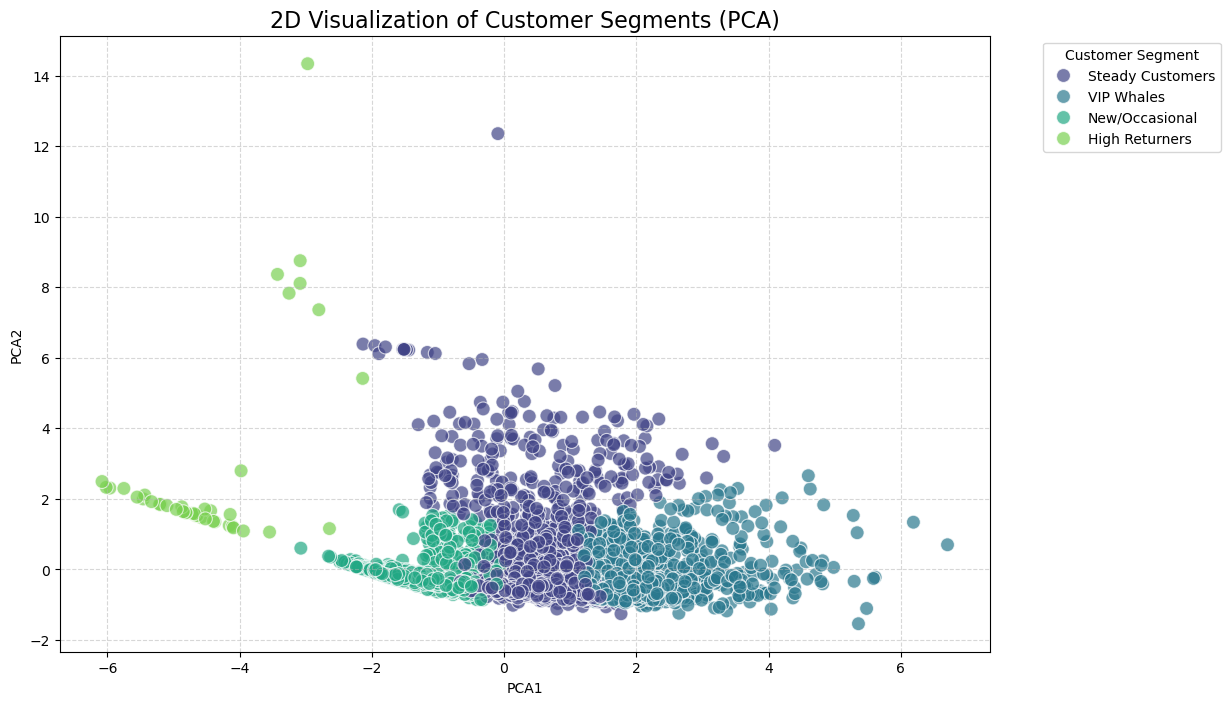

In [27]:
from sklearn.decomposition import PCA

# Reduce the 4 features down to 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features)

# Add these back to our features dataframe
features['(Principal Component Analysis) PCA1'] = pca_data[:, 0]
features['(Principal Component Analysis) PCA2'] = pca_data[:, 1]

# Create the Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=features, x='PCA1', y='PCA2', hue='Segment', 
                palette='viridis', alpha=0.7, s=100)

plt.title('2D Visualization of Customer Segments (PCA)', fontsize=16)
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
"""
Because it's impossible to visualize four dimensions at once, I used PCA to reduce the data down to two principal components.
This allowed me to create a 2D map that captures about 70-80% of the total 'information' in the dataset, confirming that our four customer segments are mathematically distinct groups.
"""

In [ ]:
## Saving customer clusters so mySQL can read them

In [29]:
import pandas as pd

# CustomerID as a column (not just an index)
output_data = final_data.reset_index()

# path
output_path = r"C:\Users\ASUS\Desktop\courses\projects\iron-man\data\clean\customer_clusters.csv"

# save to CSV
output_data.to_csv(output_path, index=False)

print(f"Results saved to: {output_path}")

Results saved to: C:\Users\ASUS\Desktop\courses\projects\iron-man\data\clean\customer_clusters.csv


In [33]:
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Load the credentials from  .env file
load_dotenv()
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

# Update the engine
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{db_name}')

# NEW features (with Log Transformation & 5 clusters)
try:
    features.reset_index().to_sql('customer_clusters', con=engine, if_exists='replace', index=False)
    print("Success! SQL database now has the balanced Log-Transformed clusters.")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    engine.dispose()

Success! SQL database now has the balanced Log-Transformed clusters.


In [36]:
import pandas as pd
import numpy as np
import os
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from dotenv import load_dotenv

# SETUP
load_dotenv()
engine = create_engine(f"mysql+mysqlconnector://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}/{os.getenv('DB_NAME')}")

# RE-RUN THE LOG LOGIC (To be 100% sure)
features_log = np.log1p(features[['Recency', 'Frequency', 'Return_Rate']])
features_log['Monetary'] = np.sign(features['Monetary']) * np.log1p(features['Monetary'].abs())

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_log)

# We use 5 clusters as per your latest successful Python plot
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
features['Cluster'] = kmeans.fit_predict(scaled_features)

# PUSH TO SQL (Overwrite the old table)
features.reset_index().to_sql('customer_clusters', con=engine, if_exists='replace', index=False)
print("SQL table overwritten")

SQL table overwritten
